In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

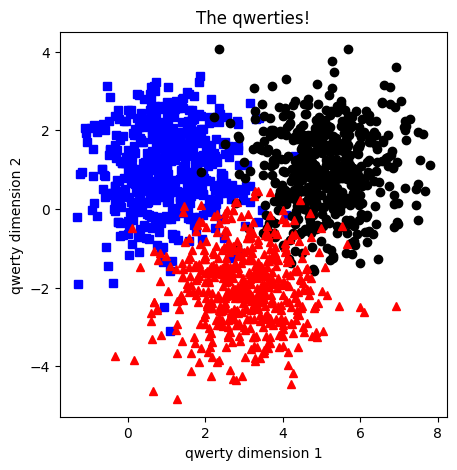

In [29]:
# create data
nPerClust = 500
blur = 1

A = [  1,  1 ]
B = [  5,  1 ]
C = [  3, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1)),1+np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [30]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

batch = 64
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [31]:
len(train_loader)

16

In [32]:
def create_model(initial_lr):
    class model(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(2, 16)
            self.hidden1 = nn.Linear(16,32)
            self.hidden2 = nn.Linear(32,20)
            self.output = nn.Linear(20,3)
        def forward(self, x):
            # doBN is a do batch norm boolean
            x = f.relu(self.input(x))
            x = f.relu(self.hidden1(x))
            x = f.relu(self.hidden2(x))
            x = self.output(x)
            return x
    net = model()
    lossfn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=initial_lr)
    step_size = batch*len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    return net, lossfn, optimizer, scheduler

In [33]:
ann, lossfn, optimizer, scheduler = create_model(0.01)

In [34]:
# Test 
ann = create_model(0.01)[0]
optimizer = torch.optim.SGD(ann.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for epoch in range(3):
    for batch in range(10):
        print(f'Batch: {batch}, epoch: {epoch}, LR: {scheduler.get_last_lr()[0]}')
        scheduler.step()

Batch: 0, epoch: 0, LR: 0.01
Batch: 1, epoch: 0, LR: 0.01
Batch: 2, epoch: 0, LR: 0.01
Batch: 3, epoch: 0, LR: 0.01
Batch: 4, epoch: 0, LR: 0.01
Batch: 5, epoch: 0, LR: 0.005
Batch: 6, epoch: 0, LR: 0.005
Batch: 7, epoch: 0, LR: 0.005
Batch: 8, epoch: 0, LR: 0.005
Batch: 9, epoch: 0, LR: 0.005
Batch: 0, epoch: 1, LR: 0.0025
Batch: 1, epoch: 1, LR: 0.0025
Batch: 2, epoch: 1, LR: 0.0025
Batch: 3, epoch: 1, LR: 0.0025
Batch: 4, epoch: 1, LR: 0.0025
Batch: 5, epoch: 1, LR: 0.00125
Batch: 6, epoch: 1, LR: 0.00125
Batch: 7, epoch: 1, LR: 0.00125
Batch: 8, epoch: 1, LR: 0.00125
Batch: 9, epoch: 1, LR: 0.00125
Batch: 0, epoch: 2, LR: 0.000625
Batch: 1, epoch: 2, LR: 0.000625
Batch: 2, epoch: 2, LR: 0.000625
Batch: 3, epoch: 2, LR: 0.000625
Batch: 4, epoch: 2, LR: 0.000625
Batch: 5, epoch: 2, LR: 0.0003125
Batch: 6, epoch: 2, LR: 0.0003125
Batch: 7, epoch: 2, LR: 0.0003125
Batch: 8, epoch: 2, LR: 0.0003125
Batch: 9, epoch: 2, LR: 0.0003125


d:\repos\udemy\.venv\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [35]:
epochs = 50
def train(initial_lr, toggle_dynamic_lr):
    ann, lossfn, optimizer, scheduler = create_model(initial_lr)
    # initialize loss
    train_acc = []
    test_acc = []
    losses = []
    currentlr = []
    # triaining
    for i in range(epochs):
        ann.train()
        batchacc = []
        batchloss = []
        for xtrain, ytrain in train_loader:
            yhat = ann(xtrain)
            loss = lossfn(yhat, ytrain)
            batchloss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # switch the dynamic learning rate on and off
            if toggle_dynamic_lr:
                scheduler.step()
            # batch accuracy
            batchacc.append(100*torch.mean((torch.argmax(yhat, axis=1) == ytrain).float()).item())
            currentlr.append(scheduler.get_last_lr()[0])
        # train accuracy
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        # model evaluation
        ann.eval()
        xtest, ytest = next(iter(test_loader))
        with torch.no_grad():
            pred = ann(xtest)
        test_acc.append(100*torch.mean((torch.argmax(pred, axis=1) == ytest).float()).item())

    return train_acc, test_acc, losses, currentlr

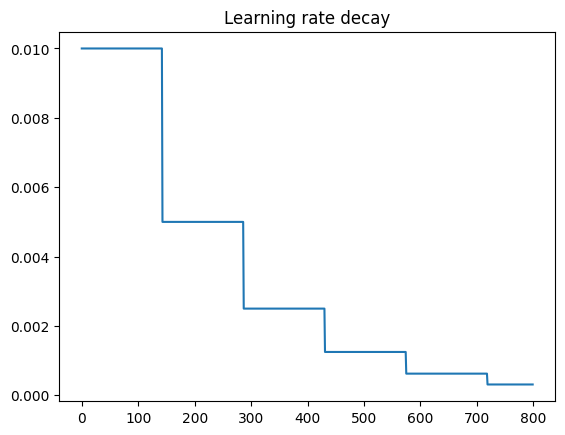

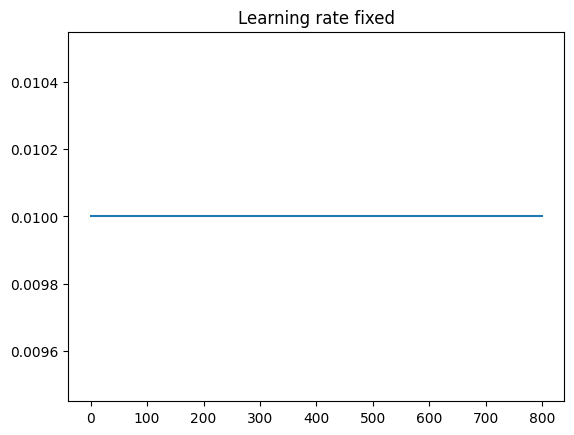

In [36]:
train_acc, test_acc, losses, currentlr = train(0.01, True)
plt.plot(currentlr)
plt.title('Learning rate decay')
plt.show()

train_acc, test_acc, losses, currentlr = train(0.01, False)
plt.plot(currentlr)
plt.title('Learning rate fixed')
plt.show()

In [37]:
train_acc_dyanmic, test_acc_dynamic, losses, currentlr = train(0.01, True)
train_acc_static, test_acc_static, losses, currentlr = train(0.01, False)

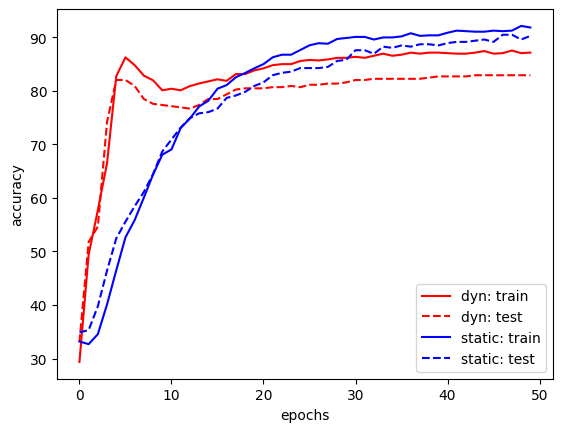

In [41]:
plt.plot(train_acc_dyanmic, 'r', label='dyn: train')
plt.plot(test_acc_dynamic, 'r--', label='dyn: test')
plt.plot(train_acc_static, 'b', label='static: train')
plt.plot(test_acc_static, 'b--', label='static: test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

- Not much is observed here because the data is small and the model is simple
- You have played around with learning rate decay, that is the take away from here